# Table of Contents
* [Framing the Problem](#frame_problem)
    - [Business objective](#goal)
    - [Evaluation metric](#metric)
    - [Data description](#data_des)
* [Getting the Data](#getting_data)
* [Exploring the Data: subset selection](#eda)
    - [Attributes characteristics](#info)
    - [Missing values](#missing)


## Framing the Problem
<a id="frame_problem"></a>

### Business Objective
<a id="goal"></a>

Significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

The goal of this project is to come up with accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

### Evaluation Metric
<a id="metric"></a>

The evaluation metric is Root Mean Squared Logarithmic Error. It is calculated as 

$\epsilon = \sqrt{\frac{1}{n}\sum^n_{i=1} \left(\log\left(p_i+1\right)-\log\left(a_i+1\right)\right)^2},$ 

where

* $n$ is the total number of observations in the (public/private) data set.
* $p_i$ is the prediction of target.
* $a_i$ is the actual target for $i$.

### Data Description
<a id="data_desc"></a>

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

These counterfactual models will bi build across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

**train.csv**
* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
* `timestamp`  - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

**building_meta.csv**
* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

**weather_[train/test].csv**

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `timestamp` - When the measurement was taken
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

**test.csv**

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file
* `building_id` - Building id code
* `meter` - The meter id code
* `timestamp` - Timestamps for the test data period

In [1]:
# Libraries

%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import datetime as dt
import gc
import missingno as msno
import pandas_profiling

from src.functions import data_import as dimp
from src.functions import data_exploration as dexp

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pty

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

## Getting the data
<a id="getting_data"></a>

In [2]:
# Training data 
TRAIN_RAW_DATA_LOC = '../../data/raw/train/'
df = dimp.import_raw_data(TRAIN_RAW_DATA_LOC)

**building_metadata.csv:
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


**train.csv:
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


**weather_train.csv:
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%




## Exploratory the data: subset selection
<a id="eda"></a>

### Attributes characteristics
<a id="info"></a>

In [3]:
# Dataset dimension
df.shape

(20216100, 16)

In [4]:
# Type of attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
site_id               int8
building_id           int16
year_built            Int16
primary_use           category
floor_count           Int16
square_feet           int32
meter                 int8
timestamp             datetime64[ns]
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
meter_reading         float32
dtypes: Int16(2), category(1), datetime64[ns](1), float16(7), float32(1), int16(1), int32(1), int8(2)
memory usage: 944.7 MB


In [14]:
# Dataset sample
df.head()

,site_id,building_id,timestamp,year_built,primary_use,floor_count,square_feet,meter,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0,0,2016-01-01 00:00:00,2008,Education,NaN,7432,0,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000,0.0
1,0,0,2016-01-01 01:00:00,2008,Education,NaN,7432,0,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000,0.0
2,0,0,2016-01-01 02:00:00,2008,Education,NaN,7432,0,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,0.0
3,0,0,2016-01-01 03:00:00,2008,Education,NaN,7432,0,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000,0.0
4,0,0,2016-01-01 04:00:00,2008,Education,NaN,7432,0,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609,0.0


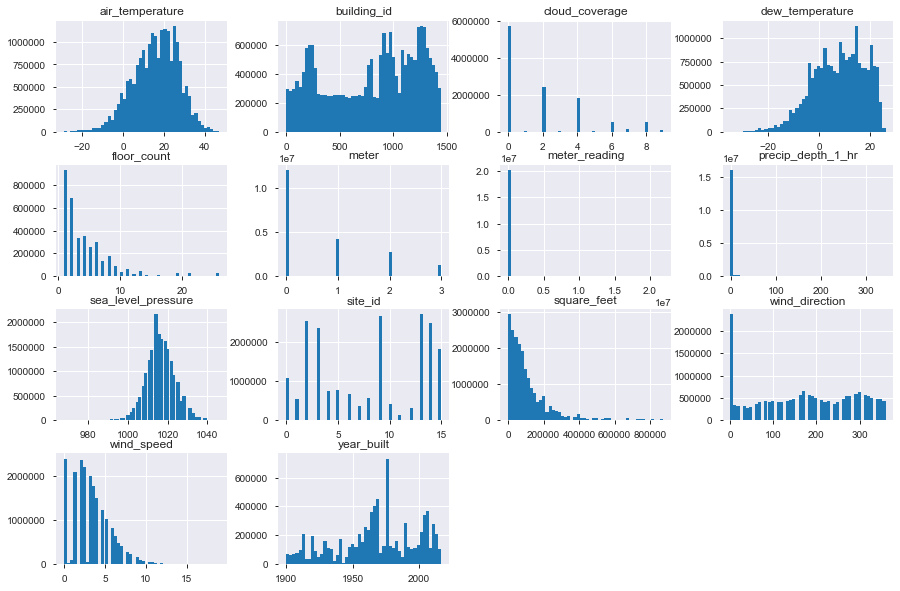

In [15]:
# Type of distribution for numerical attributes
%matplotlib inline
df.drop('timestamp', axis=1).hist(bins=50, figsize=(15,10))
plt.show()

### Missing values
<a id="missing"></a>

In [3]:
# Setting mutiple index for aggregation operations
df.set_index(['site_id','building_id','timestamp'], inplace=True)
df.head()

year_built primary_use  floor_count  \
site_id building_id timestamp                                                  
0       0           2016-01-01 00:00:00        2008   Education          NaN   
                    2016-01-01 01:00:00        2008   Education          NaN   
                    2016-01-01 02:00:00        2008   Education          NaN   
                    2016-01-01 03:00:00        2008   Education          NaN   
                    2016-01-01 04:00:00        2008   Education          NaN   

                                         square_feet  meter  air_temperature  \
site_id building_id timestamp                                                  
0       0           2016-01-01 00:00:00         7432      0        25.000000   
                    2016-01-01 01:00:00         7432      0        24.406250   
                    2016-01-01 02:00:00         7432      0        22.796875   
                    2016-01-01 03:00:00         7432      0        21.093750   
                    2016-01-01 04:00:00         7432      0        20.000000   

                                         cloud_coverage  dew_temperature  \
site_id building_id timestamp                                              
0       0           2016-01-01 00:00:00             6.0         20.00000   
                    2016-01-01 01:00:00             NaN         21.09375   
                    2016-01-01 02:00:00             2.0         21.09375   
                    2016-01-01 03:00:00             2.0         20.59375   
                    2016-01-01 04:00:00             2.0         20.00000   

                                         precip_depth_1_hr  \
site_id building_id timestamp                                
0       0           2016-01-01 00:00:00                NaN   
                    2016-01-01 01:00:00               -1.0   
                    2016-01-01 02:00:00                0.0   
                    2016-01-01 03:00:00                0.0   
                    2016-01-01 04:00:00               -1.0   

                                         sea_level_pressure  wind_direction  \
site_id building_id timestamp                                                 
0       0           2016-01-01 00:00:00              1019.5             0.0   
                    2016-01-01 01:00:00              1020.0            70.0   
                    2016-01-01 02:00:00              1020.0             0.0   
                    2016-01-01 03:00:00              1020.0             0.0   
                    2016-01-01 04:00:00              1020.0           250.0   

                                         wind_speed  meter_reading  
site_id building_id timestamp                                       
0       0           2016-01-01 00:00:00    0.000000            0.0  
                    2016-01-01 01:00:00    1.500000            0.0  
                    2016-01-01 02:00:00    0.000000            0.0  
                    2016-01-01 03:00:00    0.000000            0.0  
                    2016-01-01 04:00:00    2.599609            0.0

In [7]:
# Percentage of missing values in each variable, grouped by site_id
dexp.get_missing_percentage(df,'site_id')

,year_built,primary_use,floor_count,square_feet,meter,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
site_id,,,,,,,,,,,,,
0,0.00,0.0,100.00,0.0,0.0,0.03,43.41,0.03,0.01,0.96,2.90,0.00,0.0
1,25.40,0.0,0.00,0.0,0.0,0.25,80.64,0.25,100.00,0.83,0.27,0.24,0.0
2,23.00,0.0,100.00,0.0,0.0,0.02,26.82,0.02,0.76,0.51,6.74,0.07,0.0
3,52.18,0.0,100.00,0.0,0.0,0.09,41.50,0.11,0.47,1.84,1.79,0.09,0.0
4,1.31,0.0,0.00,0.0,0.0,0.01,48.09,0.03,15.07,0.85,1.20,0.01,0.0
5,1.12,0.0,0.00,0.0,0.0,0.35,68.98,0.35,100.00,100.00,3.69,0.36,0.0
6,100.00,0.0,100.00,0.0,0.0,0.14,34.08,0.14,0.02,1.99,8.87,0.48,0.0
7,7.08,0.0,0.00,0.0,0.0,1.92,100.00,2.18,91.67,2.01,1.92,1.92,0.0
8,100.00,0.0,0.00,0.0,0.0,0.04,44.12,0.04,0.01,0.97,2.86,0.00,0.0


The only site with no completely missing columns is **site 4**, so **it'll be the selected site to perform a first full end-to-end analysis and modelling**.

In [11]:
df.reset_index(inplace=True)
df.head()

,site_id,building_id,timestamp,year_built,primary_use,floor_count,square_feet,meter,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0,0,2016-01-01 00:00:00,2008,Education,NaN,7432,0,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000,0.0
1,0,0,2016-01-01 01:00:00,2008,Education,NaN,7432,0,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000,0.0
2,0,0,2016-01-01 02:00:00,2008,Education,NaN,7432,0,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,0.0
3,0,0,2016-01-01 03:00:00,2008,Education,NaN,7432,0,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000,0.0
4,0,0,2016-01-01 04:00:00,2008,Education,NaN,7432,0,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609,0.0


In [12]:
df_s4 = dimp.get_data_by_site(df, 4)

In [13]:
df_s4.head()

,building_id,timestamp,year_built,primary_use,floor_count,square_feet,meter,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
6530428,565,2016-01-01 00:00:00,1954,Education,2,15326,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.25
6530429,565,2016-01-01 01:00:00,1954,Education,2,15326,0,9.398438,0.0,-2.199219,0.0,1021.5,360.0,3.099609,8.50
6530430,565,2016-01-01 02:00:00,1954,Education,2,15326,0,8.296875,0.0,-2.800781,0.0,1021.5,0.0,0.000000,7.25
6530431,565,2016-01-01 03:00:00,1954,Education,2,15326,0,7.800781,0.0,-2.800781,0.0,1021.5,90.0,1.500000,7.50
6530432,565,2016-01-01 04:00:00,1954,Education,2,15326,0,5.000000,0.0,-0.600098,0.0,1022.0,0.0,0.000000,8.00


In [14]:
df_s4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746746 entries, 6530428 to 7277173
Data columns (total 15 columns):
building_id           746746 non-null int64
timestamp             746746 non-null datetime64[ns]
year_built            736951 non-null Int16
primary_use           746746 non-null category
floor_count           746746 non-null Int16
square_feet           746746 non-null int32
meter                 746746 non-null int8
air_temperature       746664 non-null float16
cloud_coverage        387660 non-null float16
dew_temperature       746492 non-null float16
precip_depth_1_hr     634227 non-null float16
sea_level_pressure    740421 non-null float16
wind_direction        737751 non-null float16
wind_speed            746664 non-null float16
meter_reading         746746 non-null float32
dtypes: Int16(2), category(1), datetime64[ns](1), float16(7), float32(1), int32(1), int64(1), int8(1)
memory usage: 38.5 MB


In [ ]:
df_s4.profile_report(
    title='Profile Report Site 4', 
    style={'full_width':True}
)          